# Conservation Analysis and Epitope Prediction


#### Author: C. Mazzaferro, K. Fisch
#### Email: cmazzafe@ucsd.edu
#### Date: August 2016
 
## Outline of Notebook
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#ConsA">Conservation Analysis</a>
    * <a href = "#BLAST">BLAST-P</a>
    * <a href = "#MSA">Multiple Sequence Alignment</a>
    * <a href = "#Cons">Conservation Score Prediction</a>
3. <a href = "#ep_pred">Windowing and New Epitope Prediction</a>
    * <a href = "#clustering">Epitope Clustering Analysis</a>

In [ ]:
1. Run netMHCcons on full protein  DONE
2. Extract n-merized peptides   DONE
3. Calculate conservation score based on specific peptide   DONE
[4. Peptide T-Cell receptor binding]    
5. Per Protein Metrics
 - #high affinity peptides 
 - #medium affinity peptides
 - # "AVG" immunological values
    
    
Summaries
By protein
Overall summary 


<a id = "background"></a>
# Background

CRISPR (clustered regularly interspaced short palindromic repeat) is an adaptive immune system that provides protection against mobile genetic elements (viruses, transposable elements and conjugative plasmids).
CRISPR clusters contain spacers, sequences complementary to antecedent mobile elements, and target invading nucleic acids. CRISPR clusters are transcribed and processed into CRISPR RNA (crRNA). In type II CRISPR systems correct processing of pre-crRNA requires a trans-encoded small RNA (tracrRNA), endogenous ribonuclease 3 (rnc) and this protein. The tracrRNA serves as a guide for ribonuclease 3-aided processing of pre-crRNA; Cas9 only stabilizes the pre-crRNA:tracrRNA interaction and has no catalytic function in RNA processing. Subsequently Cas9/crRNA/tracrRNA endonucleolytically cleaves linear or circular dsDNA target complementary to the spacer; Cas9 is inactive in the absence of the 2 guide RNAs (gRNA). The target strand not complementary to crRNA is first cut endonucleolytically, then trimmed 3'-5' exonucleolytically. DNA-binding requires protein and both gRNAs, as does nuclease activity. Cas9 recognizes the protospacer adjacent motif (PAM) in the CRISPR repeat sequences to help distinguish self versus nonself, as targets within the bacterial CRISPR locus do not have PAMs. DNA strand separation and heteroduplex formation starts at PAM sites; PAM recognition is required for catalytic activity (PubMed:24476820). Confers immunity against a plasmid with homology to the appropriate CRISPR spacer sequences (CRISPR interference) (PubMed:21455174)

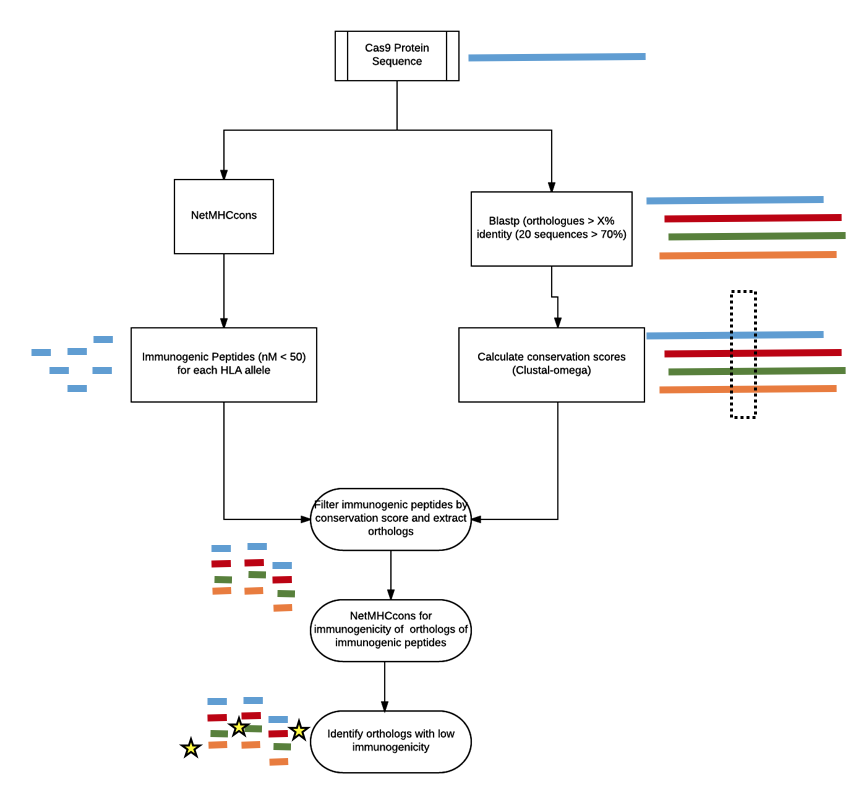

In [7]:
from IPython.display import Image
Image("/Users/carlomazzaferro/Desktop/BINF Int Rand Pics/workflow_epitope.png")

The pipeline presented here is aimed at identify the most immunogenic peptides in Cas9. By looking at multiple sequence alignment scores for the possible peptides and their associated predicted MHC affinity, we can determine which peptides within a Cas9 orthologue can be swapped in order to reduce overall immunogenecity.

The steps are constructed as follows: 

1. Run BLAST to find homolgue proteins
2. Peform Multiple Sequence Alignement (MSA) using locally installed [Clustal Omega](http://www.clustal.org/omega/) in order to determine conservation scores
3. Calculate conservation scores for each n-mer (sizes 9, 10, 11) of the MSA
4. Predict the MHC affinity of each peptide using [CBS's prediction services](http://www.cbs.dtu.dk/services/), in particular [netMHCcons Server](http://www.cbs.dtu.dk/services/NetMHCcons/)
5. Output list of highly low-conservation, high affinity peptides for in-vitro research

<a id = "ConsA"></a>
# Conservation Analysis

The package nepitope is used as a "glue" between the steps involved in epitope prediction analysis. It was designed specifically to enable the user to run the steps outlined in "Background" and rendering the inputs and outputs of each program compatible for each step. 


<a id = "BLAST"></a>
## BLAST 
Finding homologues that surpass a certain level of similarity by running BLAST on CAS9_STRP1 (UniProt ID: UniProtKB - Q99ZW2) against non-redundant databases. 
In order to retreieve the data regarding the protein, it is possible to send an HTTP request to the UniProt server by specifying the database and ID in this manner:
"http://www.uniprot.org/uniprot/Q99ZW2"

In [1]:
from nepitope import alignment_tool
from nepitope import scoring_utils
filepath = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/test.fasta'
ID = 'Q99ZW2'
website = 'uniprot'

#Wrapper to retrieve target protein in fasta format 
alignment_tool.fetch_protein(filepath, website=website, ID=ID, fetch_fasta=True)

/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/Users/carlomazzaferro/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


'File written to /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/test.fasta'

#### Run Command Line Blast 
Blast will be performed using theur RESTful API. This shouldn't be an issues since we are dealing with a single protein. 
For a thorough description of the parameters used in the BLAST analysis, refer to Biopythons [Command Line BLAST-P](http://biopython.org/DIST/docs/api/Bio.Blast.Applications.NcbiblastpCommandline-class.html) 

The output will be written as an xml file for ease of visualization and parsing. Biopython offers a variety of solutions for parsing xml data from Blast analyses.

In [39]:
#TODO: write wrapper
blastp -out /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/BLAST_out.xml -outfmt 5 -query /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/test.txt -db nr -remote -evalue 0.001

#### Visualize BLAST results

In [155]:
from nepitope import alignment_tool
from nepitope import scoring_utils
xml_filepath = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/BLAST_out.xml'
alignment_tool.viz_blast(xml_filepath)     

****Alignment****
('sequence:', u'gi|1057838392|dbj|BAV54124.1| dCas9-5xPlat2AflD-P2A-scFvGCN4sfGFPTET1CD [Cloning vector pPlatTET-gRNA2]')
('length:', 2911)
MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRR...
MDKKYSIGL IGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRR...
MDKKYSIGLAIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRR...
identities: 1366
PERCENTAGE: 0.4692545517
****Alignment****
('sequence:', u'gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper [Cloning vector pCAG-dCas9-3.5xSuper]')
('length:', 1652)
MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRR...
MDKKYSIGL IGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRR...
MDKKYSIGLAIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRR...
identities: 1366
PERCENTAGE: 0.826876513317
****Alignment****
('sequence:', u'gi|1057838381|dbj|BAV54118.1| dCas9-5xPlat2AflD [Cloning vector pCAG-dCas9-5xPlat2AflD]')
('length:', 1652)
MD

In [2]:
#Write output for protein sequences picking ones with identity > treshold values

In [3]:
treshold = 70
fasta_out = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_out_from_blast.fasta'
extra_data_out = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/extra_data_out_from_blast.fasta'
alignment_tool.write_blast_filtered_output(xml_filepath, fasta_out, treshold, extra_data_out)

## MSA (Clustal Omega)

In [35]:
#TODO: write wrapper functions 
#Run clustal omega
!clustalo -i /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/fasta_out_from_blast.fasta --residuenumber -o /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned.fasta --outfmt=fasta
#viz tool:
!mview -in clustal -ruler on -html head -coloring any /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned.clustal > /Users/carlomazzaferro/Documents/Code/clustal.html

In [51]:
#output written to msa_aligned.fasta

### Click [here](clustal.html) to see the alignment results!
(Or run next cell)

In [222]:
import os
import webbrowser
from urllib import pathname2url         

url = 'file:{}'.format(pathname2url(os.path.abspath("/Users/carlomazzaferro/clustal.html")))
webbrowser.open(url)

True

## Conservation Score Calculation
The Score class will take as input the n-mers of interest and will calculate conservation scores for each nmer as sliding window. Hence, each possible peptide's conservation score will be evaluated.

The method here reported is a reprodcution of the following [paper](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4278717/#s4) (see Materials and Methods, section: "Conservation and binding scores test for vaccine candidate classification"): 

**Goodswen SJ, Kennedy PJ, Ellis JT**. Enhancing In Silico Protein-Based Vaccine Discovery for Eukaryotic Pathogens Using Predicted Peptide-MHC Binding and Peptide Conservation Scores. Kestler HA, ed. PLoS ONE. 2014;9(12):e115745. doi:10.1371/journal.pone.0115745.

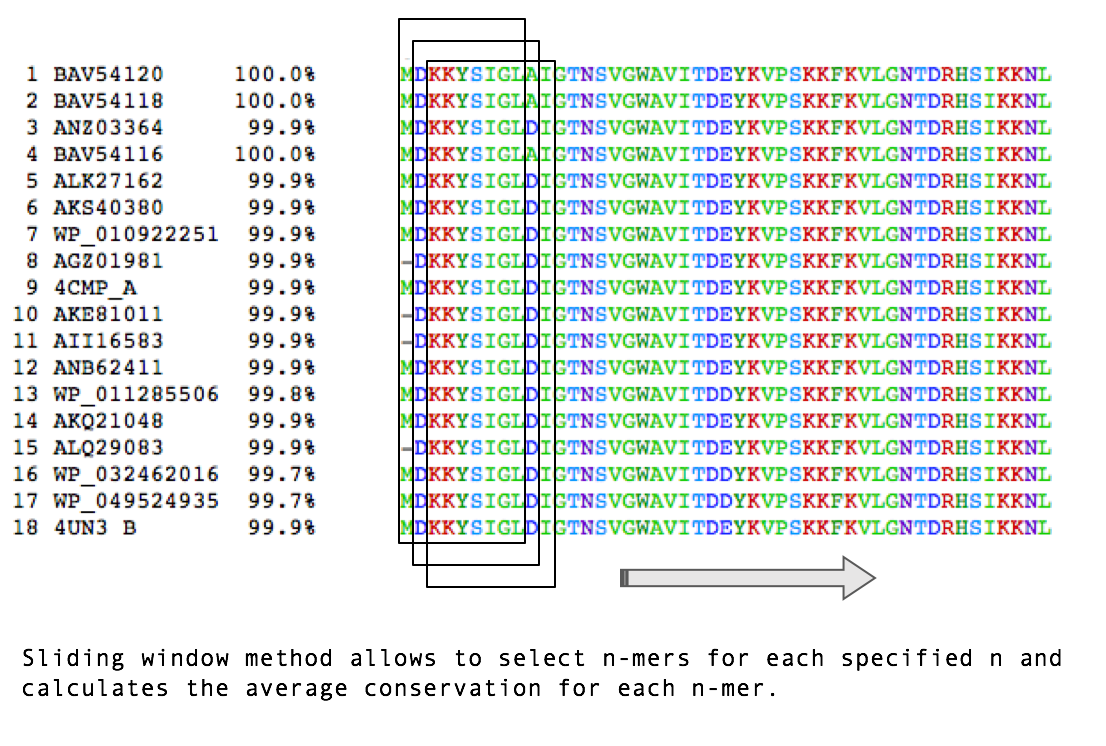

In [8]:
Image("/Users/carlomazzaferro/Desktop/BINF Int Rand Pics/windowing.png")

In [156]:
from nepitope import scoring_utils
import logging
reload(logging)
msa_alig = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned.fasta'
out_file_dir = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/nmers_out/'
#Create class instance
cls = scoring_utils.Score(msa_alig, [8,9,10,11])

### Create 'window' files for each possible nmer/peptide combination

#### Windowing

*Input*: clustal omega MSA file in FASTA format

*Output*: a file for each combination of window and window size

The output files will then be processed with an appropriate Score class

In [37]:
out_file_dir = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/nmers_out/'
cls.make_windows(out_file_dir)

1393


'All files written to /Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/nmers_out/'

### Scoring

Scoring methodology implemented is based on [Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence). For an in-depth discussion of the methodology and background, see the [original paper](http://bioinformatics.oxfordjournals.org/content/23/15/1875.short) in which the method was first discussed for MSA scoring purposes.

*Input*: directory of window files

*Output*: dataframe containing list of every possible peptide and its associated conservation score

In [157]:
out_file_dir = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/nmers_out/'
score_list = cls.run_scoring(out_file_dir)

In [39]:
score_list[0]

[0.77864625, 'MDKKYSIG', 8]

In [158]:
import pandas
score_df = pandas.DataFrame(score_list, columns=['Score', 'Peptide', 'n-mer'])
score_df.head()

,Score,Peptide,n-mer
0,0.778646,MDKKYSIG,8
1,0.767415,DKKYSIGL,8
2,0.837496,IGTNSVGW,8
3,0.728412,LEESFLVE,8
4,0.776397,NAVVGTAL,8


# MHC Binding Affinity Prediction

Run for a specific protein sequence - in reality this step will be performed for as many proteins as possible. In this case, the following protein was used (retrieved from BLAST):
> sp|Q99ZW2|CAS9_STRP1 CRISPR-associated endonuclease Cas9/Csn1 OS=Streptococcus pyogenes serotype M1 GN=cas9 PE=1 SV=1`

In [4]:
#Prepare prot for netMHCcons
file_fasta = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned.fasta'
netMHC_fasta = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/msa_aligned_net_MHCready.fasta'

with open(file_fasta, 'r') as infile, open(netMHC_fasta, 'w') as outfile:
    for line in infile:
        outfile.write(line.replace('-', 'X'))
        

# netMHCcons on full proteins

NetMHCcons 1.1 server predicts binding of peptides to any known MHC class I molecule. This is a consensus method for MHC class I predictions integrating three state-of-the-art methods NetMHC, NetMHCpan and PickPocket to give the most accurate predictions. The server also allows to use each of these methods separately:

- NetMHC is an artificial neural network-based (ANN) allele-specific method which has been trained using 94 MHC class I alleles. Version 3.4 is used as part of NetMHCcons-1.1.

- NetMHCpan is a pan-specific ANN method trained on more than 115,000 quantitative binding data covering more than 120 different MHC molecules. Version 2.8 is used as part of NetMHCcons-1.1.

- PickPocket method is matrix-based and relies on receptor-pocket similarities between MHC molecules. It has been trained on 94 different MHC alleles. In the PickPocket version 1.1, the matrices of pocket-library are generated using the SMMPMBEC method.

NetMHCcons: a consensus method for the major histocompatibility complex class I predictions
Edita Karosiene, Claus Lundegaard, Ole Lund and Morten Nielsen
PMID: [22009319](http://www.ncbi.nlm.nih.gov/pubmed/22009319)

#### Load file

In [159]:
from nepitope import scoring_utils
nmers = [9,10,11]

#files saved from netMHCcons as split_*i*_prediction_*n*_mer for each split/nmer
filepath = '/Users/carlomazzaferro/Desktop/Test_IEDB/ful_prot_all.xls'

aggregate_all = scoring_utils.FileConsolidation.load_full_multiprot_file(filepath)

/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2869: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Return data in a list of dataframes, where each dataframe contains data about a protein
(May take some time)


In [160]:
df1 = aggregate_all.return_df_list()
lsss = aggregate_all.list_df_by_prot(df1)

nepitope/scoring_utils.py:596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  list_dfs[i]['Allele'] = allele_list[i]
nepitope/scoring_utils.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['Affinity Level'] = df1.apply(lambda row: self.label_affinity(row), axis=1)
nepitope/scoring_utils.py:520: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

#### Viz data in first protein

In [162]:
lsss[0].sort_values(by='nM').head(10) #Some high affinity peps in protein BAV54116

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer
123255,0.879,3.70,0.01,1287,EIIEQISEF,BAV54120,HLA-A26:01,High,9
123252,0.847,5.21,0.12,1284,YLDEIIEQI,BAV54120,HLA-A02:01,High,9
961,0.843,5.44,0.03,961,REVKVITL,BAV54120,HLA-B40:01,High,8
122489,0.840,5.65,0.15,521,SLLYEYFTV,BAV54120,HLA-A02:01,High,9
365784,0.838,5.77,0.01,144,STDKADLRLIY,BAV54120,HLA-A01:01,High,11
122267,0.829,6.36,0.17,299,ILLSDILRV,BAV54120,HLA-A02:01,High,9
522,0.806,8.11,0.30,522,LLYEYFTV,BAV54120,HLA-A02:01,High,8
122852,0.804,8.34,0.03,884,EVVKKMKNY,BAV54120,HLA-A26:01,High,9
366685,0.797,8.94,0.03,1045,KYFFYSNIMNF,BAV54120,HLA-A24:02,High,11
244300,0.793,9.39,0.40,452,ILTFRIPYYV,BAV54120,HLA-A02:01,High,10


## Combine conservation scores and affinity in the same dataframe

And add extra data from blast, if present

In [168]:
def assign_score_mhc_results(mhc_df, conserv_df):

    alleles = mhc_df['Allele'].unique()
    nmers = mhc_df['n-mer'].unique()

    list_dfs = []

    for i in alleles:
        for j in nmers:
            sliced = mhc_df.loc[(mhc_df['Allele'] == i) & (mhc_df['n-mer'] == j)]
            score_df = conserv_df.loc[conserv_df['n-mer'] == j]
            if len(sliced) != len(score_df):
                raise ValueError("Inconsistent sizes of dataframes to be joined.")
            
            sliced['Score'] = score_df['Score'].values
            list_dfs.append(sliced)

    resulting_df = pandas.concat(list_dfs)
    resulting_df = resulting_df.loc[resulting_df['Score'] > 0]
    resulting_df = resulting_df.loc[resulting_df['Peptide'].str.contains('X') == False]

    return resulting_df

def add_conserv_score_to_df_list(list_mhc_dfs, conserv_df):

    agg_list = []
    for i in list_mhc_dfs:
        agg_list.append(assign_score_mhc_results(i, conserv_df))

    return agg_list



In [169]:
my_test_df = lsss[0]
print len(my_test_df.loc[(my_test_df['Allele'] == 'HLA-A02:01') & (my_test_df['n-mer'] == 8)])
print len(score_df.loc[score_df['n-mer'] == 8])

1386
1386


In [170]:
scores_and_affinity_test = add_conserv_score_to_df_list(lsss, score_df)

/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [289]:
scores_and_affinity = scoring_utils.Score.add_conserv_score_to_df_list(lsss, score_df)

/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [171]:
extra_data_out = '/Users/carlomazzaferro/Desktop/BINF_rand_files/CAS9_stuff/extra_data_out_from_blast.fasta'
final_list_dfs = scoring_utils.add_blast_extra_data(scores_and_affinity_test, extra_data_out)

In [3]:
final_list_dfs[5].head(5)

NameError: name 'final_list_dfs' is not defined

# Data Summary
The class SummaryData has two classmethods: summarize_all_data, and summarize_protein data. 
The first takes as input the entire list of dataframes retrived from the previous steps, while the second takes that alongside with the accession ID of a protein of choice. 

The main method implemented alogside with the first classmethod is return_dataframe. It will return a dataframe that summarizes key information for each protein. 

With summarize_protein_data, summary information regarding a specific protein is retrieved. Methods for plotting conservation scores against affinity levels are also present.

In [2]:
summ = SummaryData.summarize_all_data(final_list_dfs, show_names=False)

NameError: name 'SummaryData' is not defined

In [210]:
df = summ.return_dataframe(num_display=None, rank_by='High Affinity Peptides Per AA')
df

,Accession ID,Title,High Affinity Peptides Per AA,Num High Affinity Peps,Num Med Affinity Peps,Num Low Affinity Peps,Num No Affinity Peps,Protein Length,Alignment Hits
75,WP_003099269,gi|489189894|ref|WP_003099269.1| type II CRISP...,9.84173,139,652,2091,55810,1368,958
77,AHY15608,gi|619740371|gb|AHY15608.1| CRISPR-associated ...,10.184,125,580,1917,52038,1273,899
78,AGM98575,gi|507918117|gb|AGM98575.1| CRISPR-associated ...,10.248,125,585,1928,52358,1281,900
79,AHY17476,gi|619742240|gb|AHY17476.1| CRISPR-associated ...,10.6471,119,569,1895,51885,1267,897
38,5B2T_B,"gi|1009083498|pdb|5B2T|B Chain B, Crystal Stru...",10.7188,128,561,1972,56079,1372,1360
81,KIS10743,gi|757406358|gb|KIS10743.1| CRISPR-Associated ...,10.7238,105,481,1658,43380,1126,793
80,ESR09095,gi|557388897|gb|ESR09095.1| CRISPR-associated ...,10.7523,109,521,1735,47855,1172,824
73,WP_012515931,gi|501507994|ref|WP_012515931.1| type II CRISP...,10.784,125,600,2039,53876,1348,964
36,5B2R_B,"gi|1009083490|pdb|5B2R|B Chain B, Crystal Stru...",10.8889,126,563,1979,56072,1372,1361
34,5B2S_B,"gi|1009083494|pdb|5B2S|B Chain B, Crystal Stru...",10.8889,126,561,1967,56086,1372,1361


The object single protein can be interrogated in a variety of manners:
Attributes of single_prot:

- my_protein (protein name)
- title (alignment title)
- high_affinity_peps (number of high affinity peptides)
- med_affinity_peps (number of intermediate affinity peptides)
- low_affinity_peps (number of low affinity peptides)
- no_affinity_peps (number of no affinity peptides)
- high_affinity_per_aa (num high affinity peptides per amino acid (protein length))
- length (protein length)
- single_hits (bumber of hits in blast alignemnt)

In [1]:
single_prot = SummaryData.summarize_protein_data(final_list_dfs, 'BAV54120')
print 'Protein: %s' % single_prot.my_protein
print 'Title: %s' % single_prot.title
print 'Length: %s' % single_prot.length
print '...'

NameError: name 'SummaryData' is not defined

Most importantly, the class also has the attribute my_df, that is the original dataframe the contains the data for each specific peptide inside the protein. The data contained in it can also be used to generate useful plots.

In [220]:
single_prot.my_df.head(10)

,1-log50k,nM,Rank,Pos,Peptide,ID,Allele,Affinity Level,n-mer,Score,Alignment Title,Length,Hits,Identity Percentage
0,0.043,31229.48,50.0,0,MDKKYSIG,BAV54120,HLA-A01:01,No,8,0.778646,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
1,0.043,31229.48,50.0,1,DKKYSIGL,BAV54120,HLA-A01:01,No,8,0.767415,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
2,0.050,29266.51,50.0,2,KKYSIGLA,BAV54120,HLA-A01:01,No,8,0.837496,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
3,0.057,26985.39,50.0,3,KYSIGLAI,BAV54120,HLA-A01:01,No,8,0.728412,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
4,0.068,24087.38,32.0,4,YSIGLAIG,BAV54120,HLA-A01:01,No,8,0.776397,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
5,0.056,27131.77,50.0,5,SIGLAIGT,BAV54120,HLA-A01:01,No,8,0.748781,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
6,0.041,32259.80,50.0,6,IGLAIGTN,BAV54120,HLA-A01:01,No,8,0.724537,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
7,0.051,28640.00,50.0,7,GLAIGTNS,BAV54120,HLA-A01:01,No,8,0.733740,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
8,0.070,23571.74,32.0,8,LAIGTNSV,BAV54120,HLA-A01:01,No,8,0.763277,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877
9,0.044,30893.41,50.0,9,AIGTNSVG,BAV54120,HLA-A01:01,No,8,0.783470,gi|1057838384|dbj|BAV54120.1| dCas9-3.5xSuper ...,1652,1366,0.826877


[11]


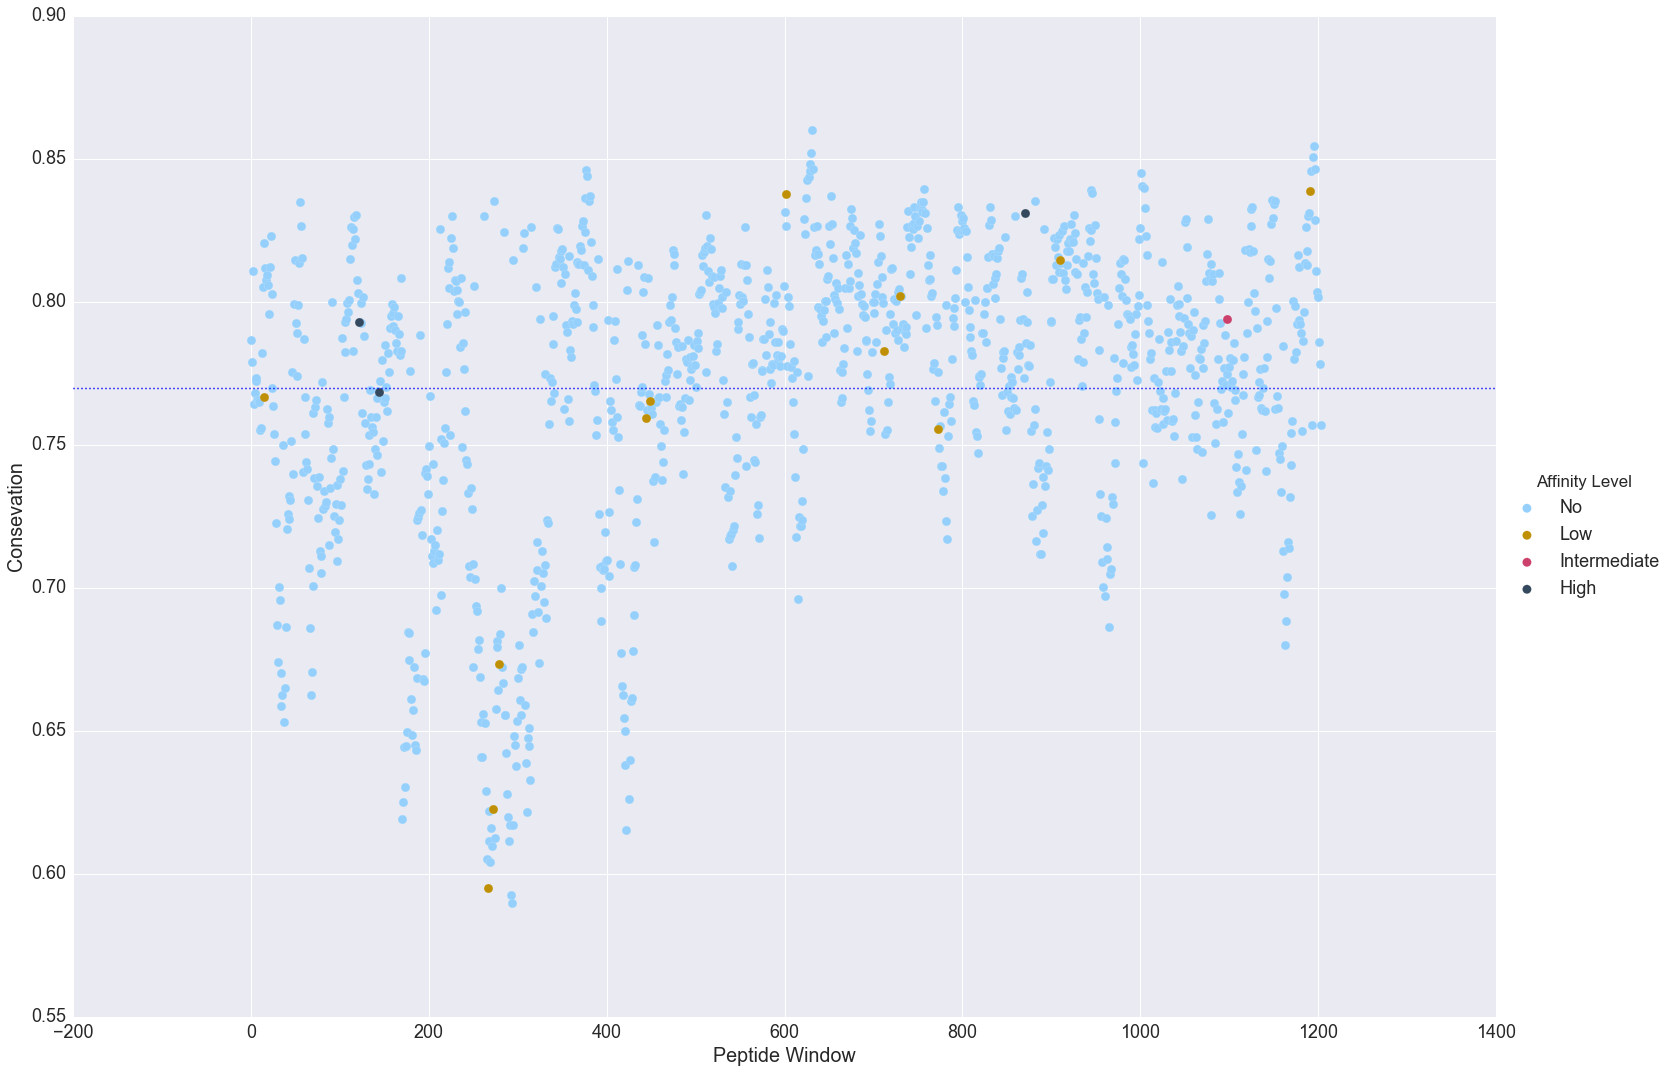

In [221]:
single_prot.plot_affinity_versus_conservation_score(nmer=11, allele='HLA-A01:01')

In [218]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; 
import numpy

%matplotlib inline
sns.set(style='ticks')


class SummaryData(object):

    @classmethod
    def summarize_all_data(cls, list_container, show_names=False):
        obj = cls()
        obj.container = list_container
        obj.proteins = obj.get_proteins(obj.container)
        obj.titles = obj.get_title()
        obj.num_prots = len(obj.proteins)
        obj.list_high_affinity_peps = obj.get_list_affinity(level='high')
        obj.list_med_affinity_peps = obj.get_list_affinity(level='med')
        obj.list_low_affinity_peps = obj.get_list_affinity(level='low')
        obj.list_no_affinity_peps = obj.get_list_affinity(level='no')
        obj.lengths = obj.get_list_lengths()
        obj.hits = obj.get_list_hits()
        obj.list_high_affinity_per_aa = obj.get_list_high_affinity_per_aa()
        
        if show_names:
            obj.display = obj.display_proteins()
        
        obj.data_list = [obj.proteins, obj.titles, obj.list_high_affinity_per_aa,
                         obj.list_high_affinity_peps, obj.list_med_affinity_peps, 
                         obj.list_low_affinity_peps, obj.list_no_affinity_peps, 
                         obj.lengths, obj.hits]
        
        obj.indexes = ['Accession ID', 'Title', 'High Affinity Peptides Per AA',
                       'Num High Affinity Peps', 'Num Med Affinity Peps', 'Num Low Affinity Peps',
                       'Num No Affinity Peps', 'Protein Length', 'Alignment Hits']
        
        return obj

    @classmethod
    def summarize_protein_data(cls, list_container, protein_of_interest):
        """
        For the situation in which a file containing all possible predictions (combinations of alleles and nmers)
        for a single protein.
        :param file_name: ex: file output from netMHCcons for 1 protein
        :return:class with attributes: protein list (should be a list with 1 object), allele list
        """
        obj = cls()
        obj.container = list_container
        obj.proteins = obj.get_proteins(obj.container)
        obj.my_protein = protein_of_interest
        obj.my_df = obj.get_df_from_prot()
        obj.title = obj.my_df["Alignment Title"].unique()[0]
        obj.high_affinity_peps = obj.get_num_high_affinity(obj.my_df)
        obj.med_affinity_peps = obj.get_num_med_affinity(obj.my_df)
        obj.low_affinity_peps = obj.get_num_low_affinity(obj.my_df)
        obj.no_affinity_peps = obj.get_num_no_affinity(obj.my_df)
        obj.high_affinity_per_aa = obj.get_high_affinity_per_aa(obj.my_df)
        obj.length = obj.get_length(obj.my_df)
        obj.single_hits = obj.get_hits(obj.my_df)
        
        return obj

    def return_dataframe(self, num_display=None, rank_by='High Affinity Peptides Per AA'):
        
        df = pandas.DataFrame(self.data_list, index=self.indexes)
        df = df.T
        if num_display:
            return df.sort_values(by=rank_by).head(num_display)
        
        else:
            return df.sort_values(by=rank_by)

    def get_df_from_prot(self):
        df = pandas.DataFrame()
        for i in self.container:
            if i["ID"].unique()[0] == self.my_protein:
                df =  i

        if df.empty:
            return "Protein not found"

        else:
            return df

    def get_list_affinity(self, level=None):
        list_affinities = []

        if level == 'high':
            for i in self.container:
                list_affinities.append(self.get_num_high_affinity(i))

        if level == 'med':
            for i in self.container:
                list_affinities.append(self.get_num_med_affinity(i))

        if level == 'low':
            for i in self.container:
                list_affinities.append(self.get_num_low_affinity(i))

        if level == 'no':
            for i in self.container:
                list_affinities.append(self.get_num_no_affinity(i))

        return list_affinities

    def get_high_affinity_per_aa(self, df):
        return float(df['Length'].unique()[0]) / self.high_affinity_peps
    
    def get_list_high_affinity_per_aa(self):
        my_list = []
        for i in range(0, len(self.container)):
            my_list.append(float(self.container[i]['Length'].unique()[0]) / self.list_high_affinity_peps[i])
        return my_list

    def get_list_lengths(self):
        
        lengths = []
        for i in self.container:
            lengths.append(self.get_length(i))
        return lengths
        
    def get_list_hits(self):
        
        hits_list = []
        for i in self.container:
            hits_list.append(self.get_hits(i))
        return hits_list
            
    @staticmethod
    def get_hits(df):
        return df.Hits.unique()[0]
    
    @staticmethod
    def get_length(df):
        return df.Length.unique()[0]
    
    @staticmethod
    def get_num_high_affinity(df):
        return len(df.loc[df["Affinity Level"] == 'High'])

    @staticmethod
    def get_num_med_affinity(df):
        return len(df.loc[df["Affinity Level"] == 'Intermediate'])

    @staticmethod
    def get_num_low_affinity(df):
            return len(df.loc[df["Affinity Level"] == 'Low'])

    @staticmethod
    def get_num_no_affinity(df):
            return len(df.loc[df["Affinity Level"] == 'No'])

    def print_table(self):
        print '.'

    @staticmethod
    def get_proteins(list_dfs):
        """
        Retrieve list of proteins from df list
        :param list_dfs: df list
        :return: list of proteins
        """
        unique_prots = []

        for i in list_dfs:
            prot_IDs = i['ID'].unique()
            unique_prots.append(prot_IDs)

        unique_prots = [item for sublist in unique_prots for item in sublist]
        return unique_prots

    def get_title(self):

        titles = []
        for i in self.container:
            titles.append(i["Alignment Title"].unique()[0])

        return titles

    def display_proteins(self):
        for i in range(0, len(self.proteins)):
            print "Protein Accession Number: %s" %self.proteins[i]
            print "Associated Alignment Title: %s \n" %self.titles[i]

            
    def plot_affinity_versus_conservation_score(self, nmer=9, allele='HLA-A01:01'):
        out_df = self.my_df.loc[(self.my_df['n-mer'] == nmer) & (self.my_df['Allele'] == allele)]
        out_df = out_df.reset_index(drop=True)
        out_df['Indx'] = out_df.index
        print out_df['n-mer'].unique()
        numpy.random.seed(0)

        _Affinity= ['No', 'Low', 'Intermediate', 'High']
        
        cols = ["#95d0fc", "#bf9005", "#cb416b", "#34495e"]
        col = sns.color_palette("Paired", n_colors=4)
        sns.set(font_scale=1.8)
        fg = sns.FacetGrid(data=out_df,palette=cols, hue='Affinity Level', 
                               hue_order=_Affinity, aspect=1.4, size=15)

        #fg.set(xlim=(-300, 14600))
        fg.map(plt.scatter, 'Indx', 'Score', s=80, linewidth=0.1, edgecolor="white").set_axis_labels("Window", "Consevation")
        fg.map(plt.axhline, y=out_df['Score'].mean(), xmin=0, xmax=1, 
               color='b', alpha=0.5, ls='dotted', lw=1.3, 
               label='Mean Conservation Score').set_axis_labels("Peptide Window", "Consevation").add_legend()
        

# Visualize and Interpret Results

Of interest here is the relationship between conservation score of a peptide and its likelihood of being a strong binder. We will plot, for each protein peptide window, the predicted affinity score (factored as high (nM<50), intermediate (50<nM<500), low (500<nM<5000) and no affinity (nM<5000)) and its corresponding conservation score. This will be done by selecting every possible n-mer for each selected length (9, 10, 11) for each protein and obtaining its affinity and conservation score. 

## Per-protein analysis: 9-mer

In [35]:
## Check how many high-affinity peptides each protein contains

In [46]:
df = scores_and_affinity.loc[scores_and_affinity['Affinity Level'] =='High']
print " %d high affinity peptides" %len(df)


 121 high affinity peptides


[(0.86, 0.37119999999999997, 0.33999999999999997), (0.56880000000000008, 0.86, 0.33999999999999997), (0.33999999999999997, 0.82879999999999987, 0.86), (0.63119999999999976, 0.33999999999999997, 0.86)]


/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


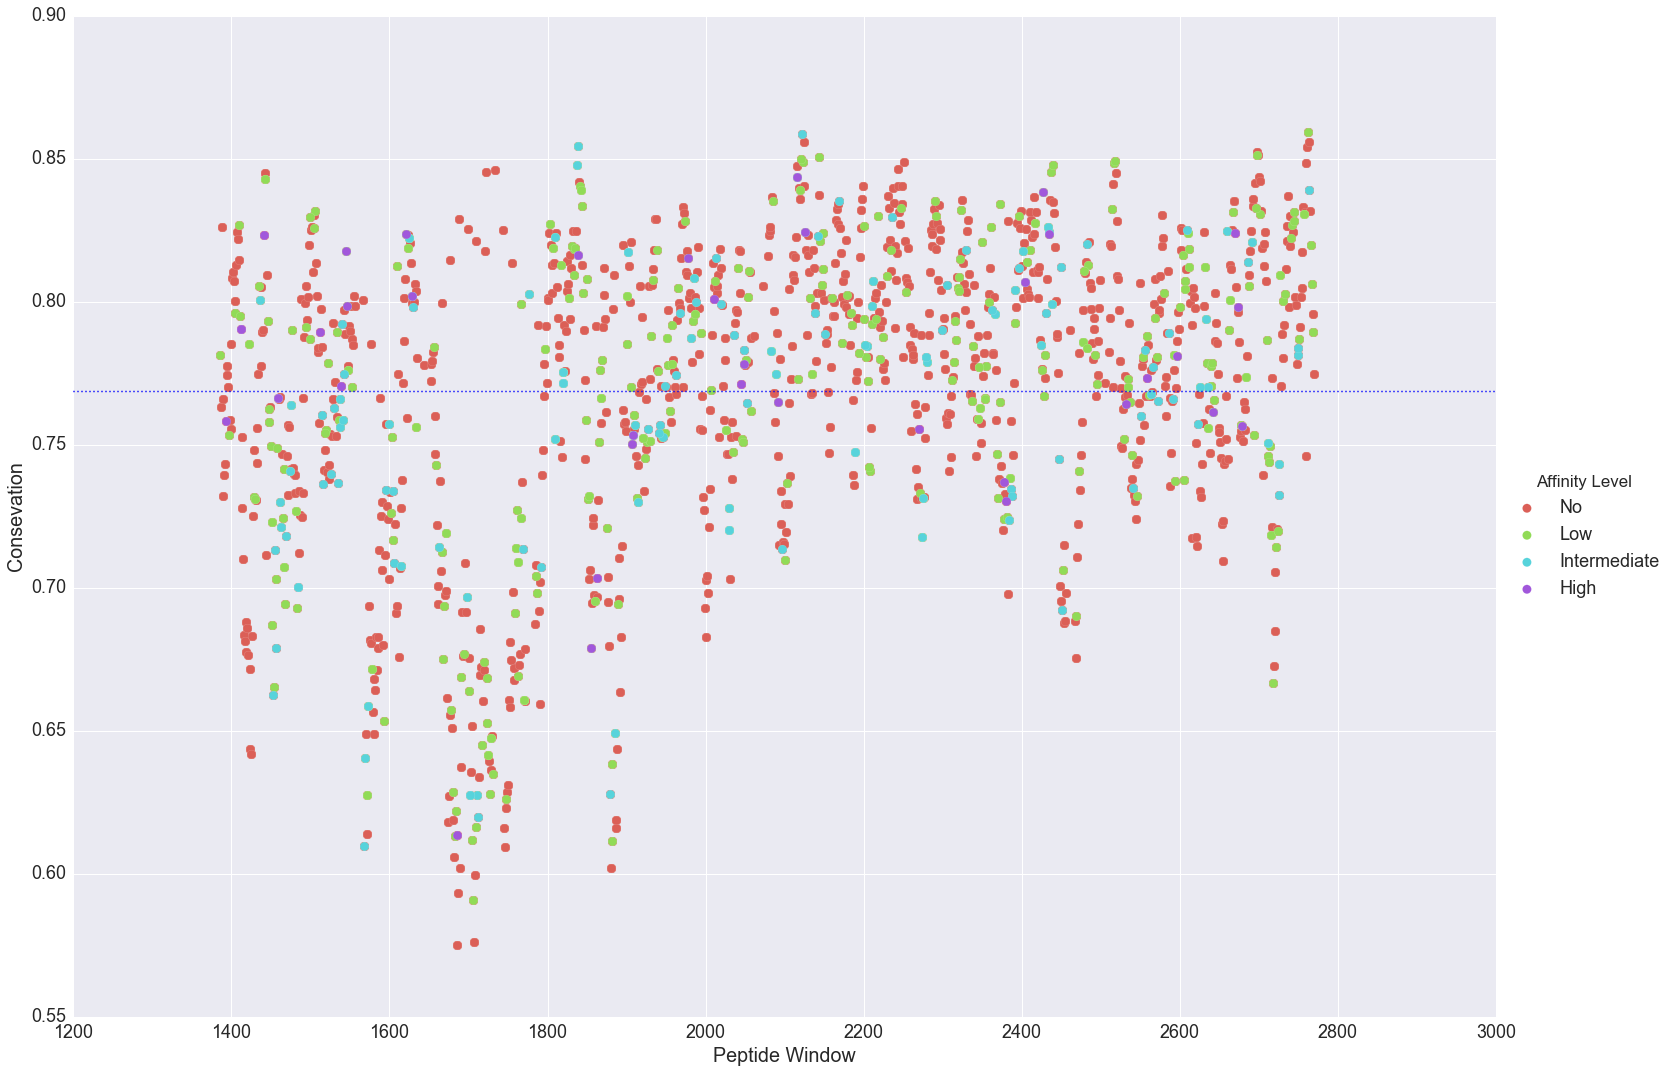

In [51]:



def plot_stuff(scores_and_affinity, nmer):
    
    out_df = scores_and_affinity.loc[(scores_and_affinity['Score'] > 0) & (scores_and_affinity['n-mer'] == nmer)]
    out_df['Indx'] = out_df.index

    numpy.random.seed(0)

    _Affinity= ['No', 'Low', 'Intermediate', 'High']

    col = sns.color_palette("hls", n_colors=4)
    sns.set(font_scale=1.8)
    fg = sns.FacetGrid(data=out_df,palette=col, hue='Affinity Level', 
                           hue_order=_Affinity, aspect=1.4, size=15)

    fg.map(plt.scatter, 'Indx', 'Score', s=80, linewidth=0.1, edgecolor="white").set_axis_labels("Window", "Consevation")
    fg.map(plt.axhline, y=out_df['Score'].mean(), xmin=0, xmax=1, 
           color='b', alpha=0.5, ls='dotted', lw=1.3, 
           label='Mean Conservation Score').set_axis_labels("Peptide Window", "Consevation").add_legend()

plot_stuff(scores_and_affinity, 9)

## Per-protein analysis: 10-mer

/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


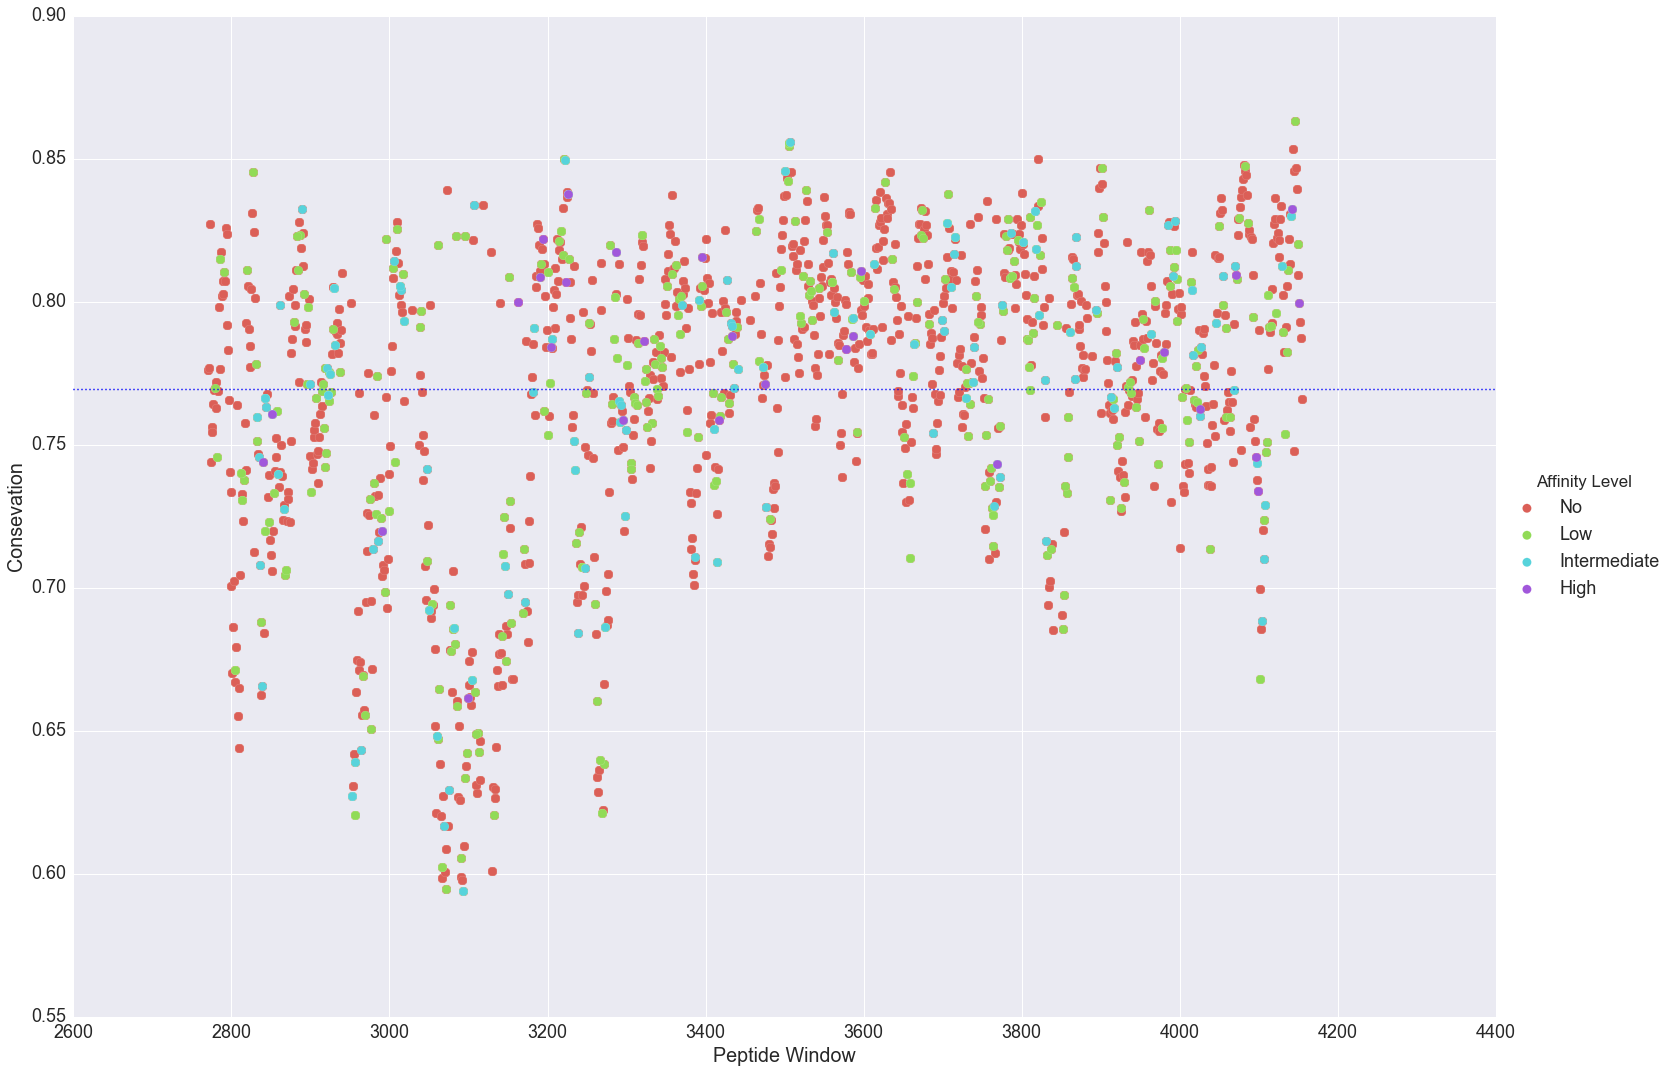

In [52]:
plot_stuff(scores_and_affinity, 10)

## Per-protein analysis: 11-mer

/Users/carlomazzaferro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


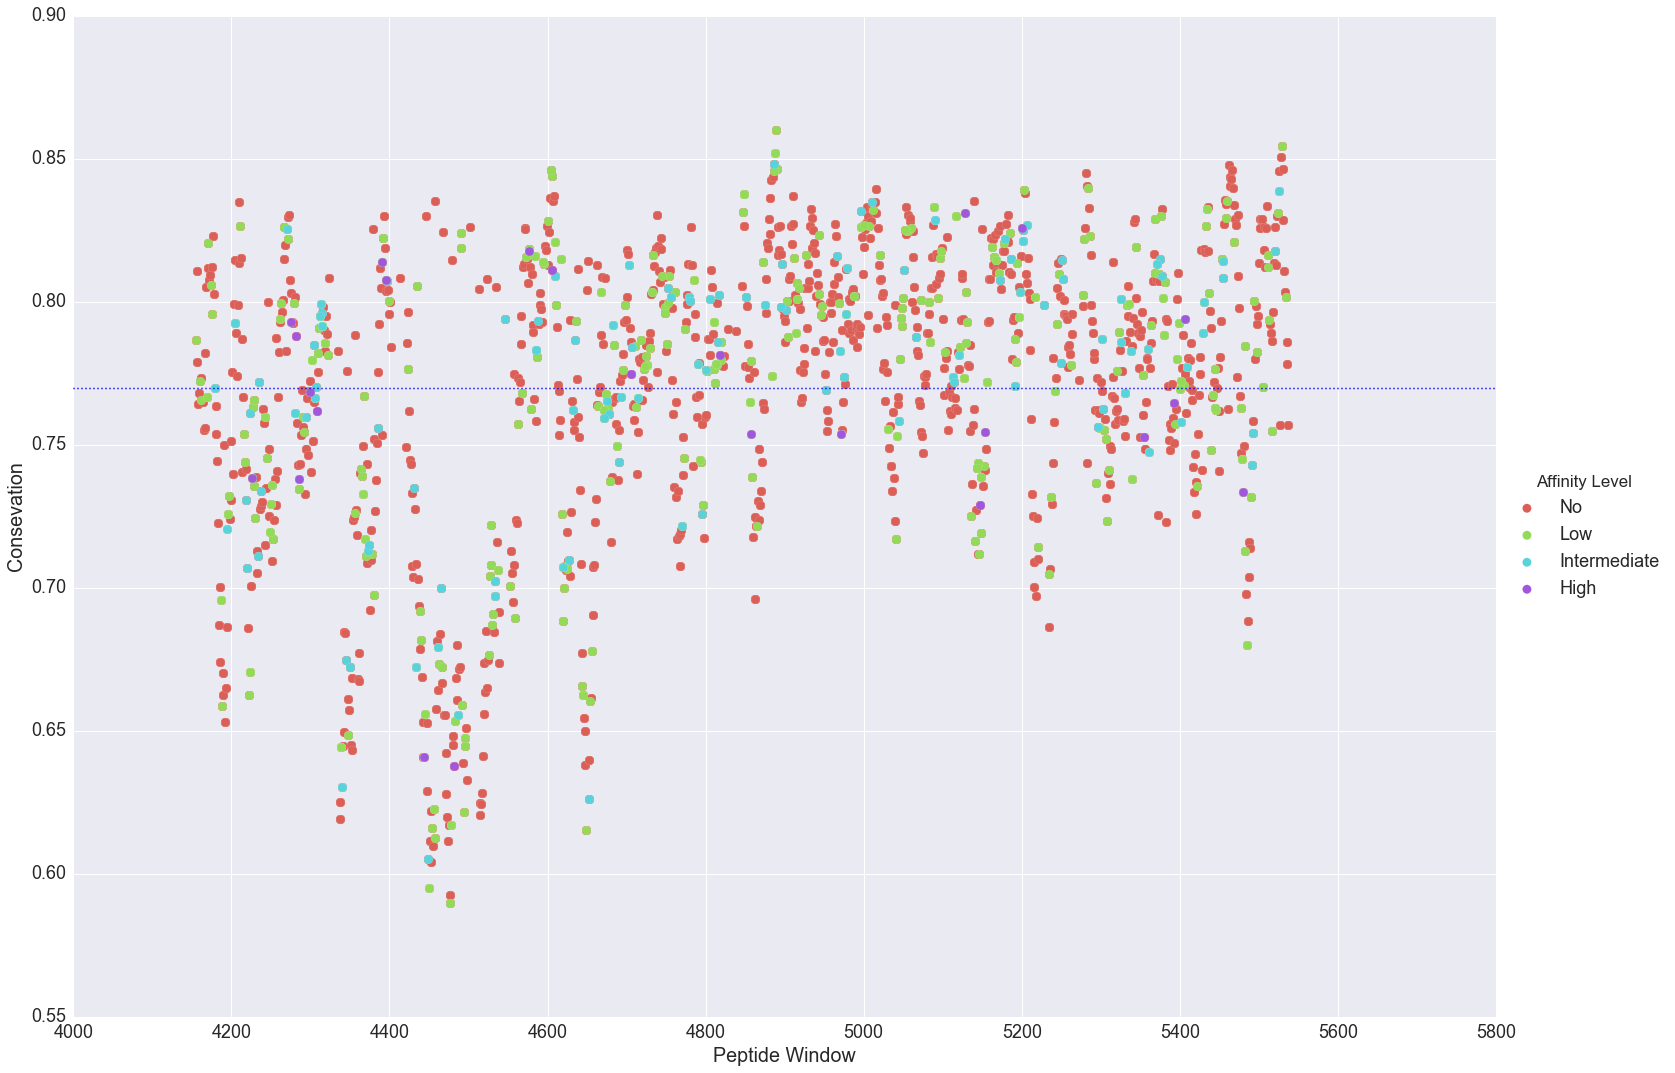

In [53]:
plot_stuff(scores_and_affinity, 11)